# Babel Stream benchmark

Results from Babel Stream benchmark.

In [1]:
import os, sys
from pprint import pprint
from pathlib import Path

REPO_ROOT = str(Path(os.getcwd()).parent.parent.parent.parent)  # Repo root dir
REFRAME_ROOT = os.path.join(REPO_ROOT, 'reframe')  # ReFrame root dir
REFRAME_DEPS = os.path.join(REFRAME_ROOT, 'external')  # ReFrame dependencies
REPO_DEPS = os.path.join(REPO_ROOT, 'external')  # Repo dependencies
PERFLOG_DIR = os.path.join(REPO_ROOT, 'perflogs-jitter')  # Perflogs dir
sys.path.extend((REFRAME_ROOT, REPO_ROOT, REPO_DEPS, REFRAME_DEPS)) # the `modules` package imports `reframe` so need that in sys.modules

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import modules
from reframe_config import site_configuration

# Plotting setup
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter
from IPython.display import display, HTML

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

## Systems and their descriptions

The following table gives a high level overview of each partition defined in terms of architecture and configuration. The column `S:C:T` stands for **number of sockets**, **number of physical cores per socket** and **number of threads per core**. Similarly, the column `caches` indicate the cache sizes from lower to higher in kilobytes (KiB).

In [3]:
df = modules.utils.tabulate_partitions(root=PERFLOG_DIR)
display(HTML(df.transpose().to_html()))

## Array size

Babel Stream benchmark uses 3 arrays of size `N` to run different kernels. We use the total array
size of the benchmark in such a way that they occupy certain percentage of the system memory to avoid caching effects of the benchmark. This can be configured from the CLI using `-S mem_size` flag. Current default is 0.4, _i.e.,_ 40 % of system memory is used for arrays.

## Latest run performance metrics

All the performance metrics in `MB/s` are tabulated from the latest benchmark run for different systems/parititons and programming environments

In [4]:
df = modules.utils.tabulate_last_perf(test='BabelStreamTest*',
                                     root=PERFLOG_DIR,
                                     extras=['prg_model'])
df = df.transpose() # so now cols are all, single
df = df.sort_values(['case'])
display(df)

perf_var                                                             Add  \
case                                               prg_model               
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... cuda       555504.561   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... omp         44502.577   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... tbb         43943.851   

perf_var                                                            Copy  \
case                                               prg_model               
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... cuda       543062.472   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... omp         39076.939   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... tbb         38599.270   

perf_var                                                             Dot  \
case                                               prg_model               
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... cuda       584563.453   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... omp         61995.467   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... tbb         61753.710   

perf_var                                                             Mul  \
case                                               prg_model               
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... cuda       542890.521   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... omp         39032.410   
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... tbb         38703.517   

perf_var                                                           Triad  
case                                               prg_model              
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... cuda       556309.193  
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... omp         44525.552  
cscs-daint:daint-gcc9-ompi4-ib-umod-gpu:babel-s... tbb         44035.255

## Performance History

The plot shows the **Triad bandwidths** for each system/partition/environment combination. The performance logs include a git reference (as a tag "git=<ref>") to refer the state of repository when the test was performed.

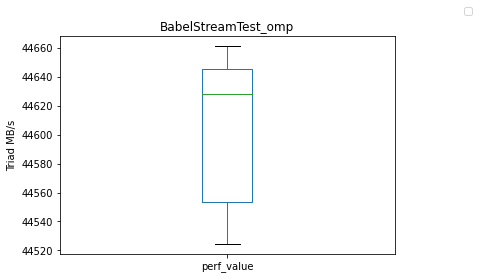

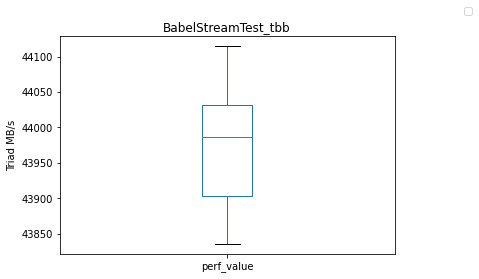

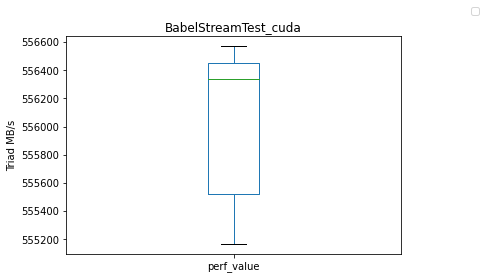

In [5]:
for model in ['omp', 'tbb', 'cuda']:
    test=f'BabelStreamTest_{model}'
    perf_records = modules.utils.load_perf_logs(root=PERFLOG_DIR, extras=[], test=test)
    if perf_records is None:
        print('%s: no performance logs found' % test)
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1)
        for spe, data in perf_records.groupby(['sysname', 'partition', 'environ']):
            # filter to only Gflops records (might have others)
            data = data.loc[data['perf_var'] == 'Triad']
            data.boxplot(ax=ax, column='perf_value')

        ax.set_title(test)
        ax.set_ylabel('Triad MB/s')
        handles, labels = ax.get_legend_handles_labels()
        ax.grid()
        fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')